In [18]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from functions import util
import json

import warnings
warnings.filterwarnings("ignore")

In [19]:
with open('../../data/hopsworkKey.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()


project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1170584
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [20]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
air_pm25rolling_fg = fs.get_feature_group(
    name='air_pm25rolling',
    version=2,
)

In [21]:
air_pm25rolling_fg.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.18s) 


,date,pm25_rolling_mean,country,city,street,url
0,2018-12-27 00:00:00+00:00,121.000000,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
1,2023-07-14 00:00:00+00:00,46.000000,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
2,2020-07-17 00:00:00+00:00,49.000000,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
3,2023-06-02 00:00:00+00:00,84.000000,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
4,2019-10-31 00:00:00+00:00,116.000000,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
5,2022-10-25 00:00:00+00:00,154.000000,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
6,2023-03-06 00:00:00+00:00,156.333333,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
7,2024-08-02 00:00:00+00:00,56.666667,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
8,2020-12-15 00:00:00+00:00,127.666667,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444
9,2019-09-19 00:00:00+00:00,46.333333,china,chengdu,chengdu-jinbo-road,https://api.waqi.info/feed/@10444


In [22]:
selected_features = air_quality_fg.select(['pm25']).join(weather_fg.select_all(), on=['city']).join(air_pm25rolling_fg.select(['pm25_rolling_mean']), on=['city'])
selected_features.show(10)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.97s) 


,pm25,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling_mean
0,59.0,2018-07-01 00:00:00+00:00,26.234335,14.500000,11.966954,51.279083,chengdu,78.666667
1,47.0,2018-07-02 00:00:00+00:00,22.838501,86.199997,31.311722,24.439882,chengdu,74.000000
2,28.0,2018-07-03 00:00:00+00:00,24.530167,5.700000,19.694992,17.713129,chengdu,50.666667
3,51.0,2018-07-04 00:00:00+00:00,24.119751,2.700000,8.496305,297.159698,chengdu,44.666667
4,60.0,2018-07-05 00:00:00+00:00,26.261415,0.500000,10.853866,34.481857,chengdu,42.000000
5,46.0,2018-07-06 00:00:00+00:00,26.475998,0.500000,20.746122,27.939043,chengdu,46.333333
6,67.0,2018-07-07 00:00:00+00:00,24.615585,14.499999,14.458382,8.018564,chengdu,52.333333
7,79.0,2018-07-08 00:00:00+00:00,23.332251,101.299995,16.243940,18.855301,chengdu,57.666667
8,33.0,2018-07-09 00:00:00+00:00,22.773918,13.000001,17.577440,20.601685,chengdu,64.000000
9,67.0,2018-07-10 00:00:00+00:00,24.748915,52.799999,12.287555,28.157293,chengdu,59.666667


In [28]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv2',
    description="weather features and mean of 3days aq(today+2 previous day) with air quality as the target",
    version=2,
    labels=['pm25'],
    query=selected_features,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1170584/fs/1161287/fv/air_quality_fv2/version/2


In [30]:
X_train, X_test, y_train, y_test=feature_view.train_test_split(test_size=0.2)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.40s) 


In [31]:
train_features = X_train.drop(['date', 'city'], axis=1)
test_features = X_test.drop(['date', 'city'], axis=1)
train_features

,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,pm25_rolling_mean
1,22.838501,86.199997,31.311722,24.439882,74.000000
4,26.261415,0.500000,10.853866,34.481857,42.000000
5,26.475998,0.500000,20.746122,27.939043,46.333333
6,24.615585,14.499999,14.458382,8.018564,52.333333
7,23.332251,101.299995,16.243940,18.855301,57.666667
...,...,...,...,...,...
2288,17.350000,0.000000,4.024922,26.564985,60.333333
2289,16.549999,0.000000,8.759178,9.462248,71.666667
2290,15.100000,0.000000,5.588703,14.931467,72.666667
2291,11.150000,0.000000,11.709688,44.999897,63.000000


In [32]:
y_train

,pm25
1,47.0
4,60.0
5,46.0
6,67.0
7,79.0
...,...
2288,102.0
2289,74.0
2290,13.0
2291,25.0


In [33]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(train_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [34]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 1065.6108
R squared: 0.4009282577883967


In [35]:
df = y_test
df['predicted_pm25'] = y_pred
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
0,59.0,73.878197,2018-07-01 00:00:00+00:00
2,28.0,39.532806,2018-07-03 00:00:00+00:00
3,51.0,50.605450,2018-07-04 00:00:00+00:00
14,67.0,72.784691,2018-07-15 00:00:00+00:00
20,64.0,99.533295,2018-07-21 00:00:00+00:00


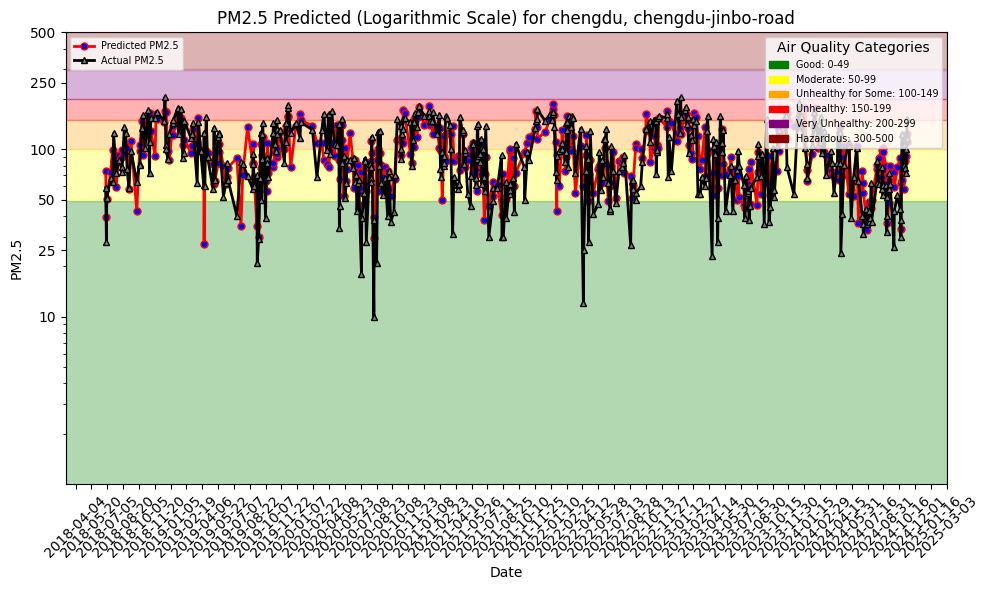

In [36]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model_2"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)
file_path = images_dir + "/pm25_hindcast_2.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

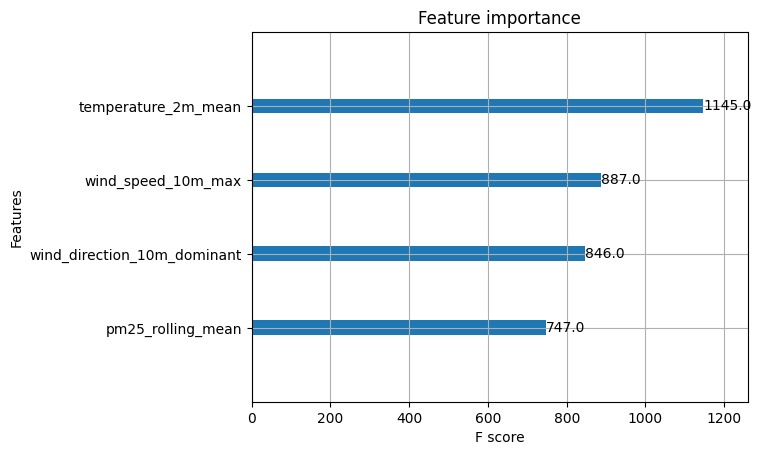

In [37]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor, max_num_features=4)
feature_importance_path = images_dir + "/feature_importance_2.png"
plt.savefig(feature_importance_path)
plt.show()

In [38]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model_2.json")

In [39]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [40]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model_3", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/503537 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/482621 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/19108 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/150463 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/140 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/766 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1170584/models/air_quality_xgboost_model_3/5


Model(name: 'air_quality_xgboost_model_3', version: 5)

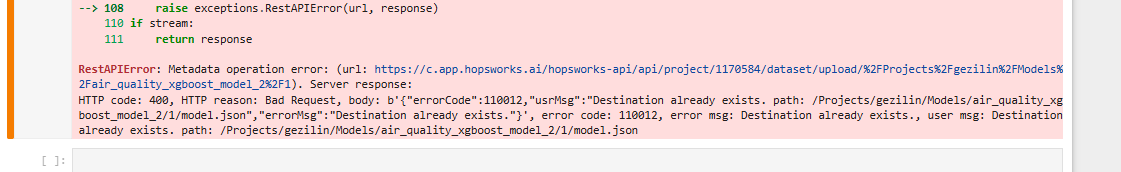